# Tensorflow Timeseries Classification

## Import packages

In [1]:
import tensorflow as tf
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
from GetData import getData

## Load dataset

In [2]:
ticker =  'GOOGL' 
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 7, 31)
# download ticker ‘Adj Close’ price from yahoo finance
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)
stock = pd.DataFrame(stock)
stock.drop('Dividends', axis=1, inplace=True)
stock.drop('Stock Splits', axis=1, inplace=True)
stock.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,312.687683,313.013000,310.300293,310.300293,310.300293,2437160
2010-01-04,313.788788,315.070068,312.432434,313.688690,313.688690,3908488


In [3]:
print(len(stock))

2663


## Split dataset

In [4]:
x_train=stock.sample(frac=0.8,random_state=200)
x_test=stock.drop(x_train.index)

y_train = np.where(x_train.Close.shift(-1) > x_train.Close, 1, 0)
y_train = pd.DataFrame(y_train, columns={'y'})  

y_test = np.where(x_test.Close.shift(-1) > x_test.Close, 1, 0)
y_test = pd.DataFrame(y_test, columns={'y'})   

In [5]:
columns = x_train.columns

In [6]:
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

In [7]:
tf.convert_to_tensor(x_train)
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(x_train)

## Build a machine learning model
Build a tf.keras.Sequential model by stacking layers.

In [8]:
model = tf.keras.Sequential([
  normalizer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [9]:
predictions = model(x_train).numpy()
predictions

array([[ 0.02189778, -0.06582812, -0.38277224, ...,  0.41690287,
         0.04295434,  0.12604427],
       [-0.05057315,  0.14462227,  0.05397422, ...,  0.06770889,
        -0.03266859, -0.03005688],
       [-0.00713235,  0.00430916, -0.0617858 , ...,  0.02145597,
         0.03682272, -0.00420803],
       ...,
       [-0.10141663,  0.26186016,  0.12096799, ...,  0.13219063,
        -0.07850999, -0.05213208],
       [-0.13132839,  0.17629778,  0.18606558, ...,  0.17747247,
        -0.15415132, -0.02963877],
       [ 0.03183487, -0.04669146, -0.41951495, ...,  0.43705243,
         0.02248639,  0.16159187]], dtype=float32)

In [10]:
tf.nn.softmax(predictions).numpy()

array([[0.09302427, 0.08521134, 0.06206551, ..., 0.13808446, 0.09500381,
        0.10323489],
       [0.09475774, 0.11518263, 0.1052008 , ..., 0.10665567, 0.09646962,
        0.0967219 ],
       [0.09959672, 0.10074279, 0.09429949, ..., 0.10248511, 0.10407214,
        0.0998884 ],
       ...,
       [0.08937557, 0.1285251 , 0.11163471, ..., 0.1128946 , 0.09144649,
        0.09389075],
       [0.08786636, 0.11951514, 0.12068827, ..., 0.11965562, 0.08588369,
        0.09727155],
       [0.09350724, 0.08644536, 0.05954242, ..., 0.14022614, 0.09263717,
        0.10646283]], dtype=float32)

In [11]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [12]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [13]:
model.fit(x_train, y_train, epochs=200)

Epoch 1/5
67/67 [==============================] - 0s 2ms/step - loss: 1.3981 - accuracy: 0.6502
Epoch 2/5
67/67 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.7507
Epoch 3/5
67/67 [==============================] - 0s 2ms/step - loss: 0.5911 - accuracy: 0.7460
Epoch 4/5
67/67 [==============================] - 0s 2ms/step - loss: 0.5564 - accuracy: 0.7507
Epoch 5/5
67/67 [==============================] - 0s 2ms/step - loss: 0.5437 - accuracy: 0.7526


In [14]:
model.evaluate(x_test,  y_test, verbose=2)

17/17 - 0s - loss: 0.9358 - accuracy: 0.4859


[0.9358494281768799, 0.4859287142753601]

In [15]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [16]:
probability_model(x_test)

<tf.Tensor: shape=(533, 10), dtype=float32, numpy=
array([[1.40261501e-01, 8.59341860e-01, 5.98074666e-06, ...,
        7.05982602e-05, 2.08261790e-05, 6.95944036e-05],
       [1.49872288e-01, 8.49779010e-01, 5.87129671e-06, ...,
        5.88185831e-05, 2.02542833e-05, 5.83111178e-05],
       [1.70316324e-01, 8.29184771e-01, 9.90469107e-06, ...,
        8.22213406e-05, 3.11521871e-05, 7.95907181e-05],
       ...,
       [9.40063834e-01, 5.98816797e-02, 1.17398140e-05, ...,
        1.39759977e-05, 4.94353026e-06, 6.24200629e-06],
       [9.42358971e-01, 5.76350838e-02, 1.40424038e-06, ...,
        1.27347903e-06, 6.43942656e-07, 5.85611247e-07],
       [9.61720705e-01, 3.82789448e-02, 1.31351413e-07, ...,
        1.10491115e-07, 5.25045252e-08, 4.56724436e-08]], dtype=float32)>

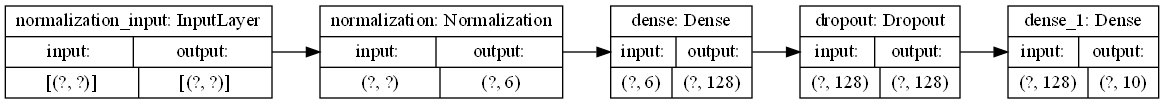

In [17]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)